In [4]:
import pandas as pd
from sqlalchemy import create_engine
import os 
from dotenv import load_dotenv

In [5]:
# Load environment variables
dotenv_path = os.path.join(os.path.dirname(os.getcwd()), 'config', '.env')
load_dotenv(dotenv_path=dotenv_path)

engine = create_engine(f"postgresql://{os.getenv('DB_USER')}:{os.getenv('DB_PASSWORD')}@{os.getenv('DB_HOST')}:{os.getenv('DB_PORT')}/{os.getenv('DB_NAME')}")


In [6]:
data = pd.read_sql("SELECT * FROM discount_impact_analysis", engine)
data.head(12)
#data.info()

,discount_band,order_status,num_orders,total_value,total_profit,avg_discount,completed_orders,lost_orders,total_orders,pct_of_band
0,High,Cancelled,194,184203.890145,NaN,27.516392,225.0,618.0,843.0,23.01
1,High,Completed,225,239694.845028,196726.644736,27.513244,225.0,618.0,843.0,26.69
2,High,Pending,213,232140.511841,NaN,27.493474,225.0,618.0,843.0,25.27
3,High,Returned,211,207012.794411,NaN,27.635118,225.0,618.0,843.0,25.03
4,Low,Cancelled,413,558695.374492,NaN,5.005521,425.0,1284.0,1709.0,24.17
5,Low,Completed,425,547107.184975,461786.944343,5.053671,425.0,1284.0,1709.0,24.87
6,Low,Pending,397,525283.527902,NaN,4.945340,425.0,1284.0,1709.0,23.23
7,Low,Returned,474,629169.349957,NaN,5.086139,425.0,1284.0,1709.0,27.74
8,Medium,Cancelled,609,697192.198220,NaN,17.655599,581.0,1866.0,2447.0,24.89
9,Medium,Completed,581,689299.335515,572731.830312,17.570981,581.0,1866.0,2447.0,23.74


In [7]:
# Step 1: Filter completed orders
completed = data[data["order_status"] == "Completed"].copy()

# Step 2: Compute per-order metrics
completed["avg_profit_per_order"] = completed["total_profit"] / completed["num_orders"]
completed["avg_order_value"] = completed["total_value"] / completed["num_orders"]
completed["profit_margin"] = completed["total_profit"] / completed["total_value"]

# Step 3: Summarize key metrics per discount band
completed_summary = completed[[
    "discount_band",
    "avg_discount",
    "avg_profit_per_order",
    "avg_order_value",
    "profit_margin"
]].drop_duplicates().copy()

completed_summary


,discount_band,avg_discount,avg_profit_per_order,avg_order_value,profit_margin
1,High,27.513244,874.340643,1065.310422,0.820738
5,Low,5.053671,1086.557516,1287.311023,0.844052
9,Medium,17.570981,985.769071,1186.401610,0.830890


/tmp/ipykernel_24423/311747711.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=completed_summary, x="discount_band", y="avg_profit_per_order", palette="viridis")


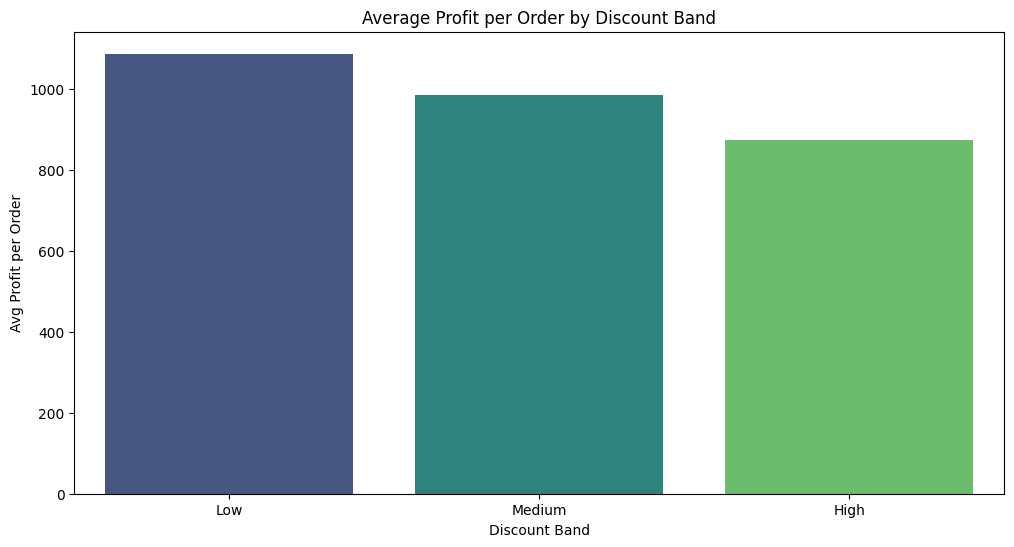

/tmp/ipykernel_24423/311747711.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=completed_summary, x="discount_band", y="profit_margin", palette="rocket")


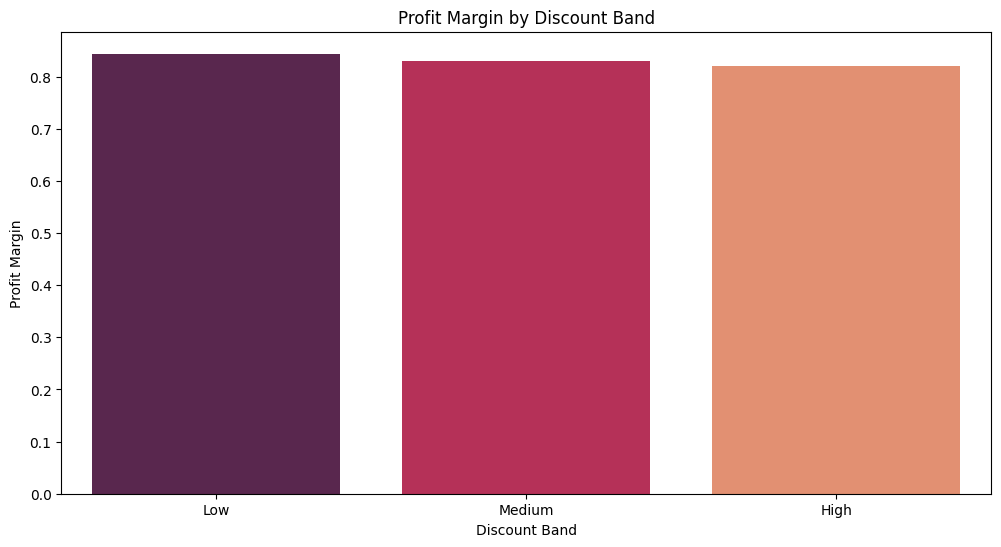

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.barplot(data=completed_summary, x="discount_band", y="avg_profit_per_order", palette="viridis")
plt.title("Average Profit per Order by Discount Band")
plt.ylabel("Avg Profit per Order")
plt.xlabel("Discount Band")
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=completed_summary, x="discount_band", y="profit_margin", palette="rocket")
plt.title("Profit Margin by Discount Band")
plt.ylabel("Profit Margin")
plt.xlabel("Discount Band")
plt.show()


In [21]:
completed.columns


Index(['discount_band', 'order_status', 'num_orders', 'total_value',
       'total_profit', 'avg_discount', 'completed_orders', 'lost_orders',
       'total_orders', 'pct_of_band', 'avg_profit_per_order',
       'avg_order_value', 'profit_margin'],
      dtype='object')

In [8]:
# Step 4: Aggregate total number of orders per band
order_counts = completed.groupby("discount_band", as_index=False)["num_orders"].sum()

# Step 5: Ensure both discount_band columns are strings (to prevent mismatches during merge)
completed_summary["discount_band"] = completed_summary["discount_band"].astype(str)
order_counts["discount_band"] = order_counts["discount_band"].astype(str)

# Step 6: Merge order counts with summary
completed_summary = pd.merge(
    completed_summary,
    order_counts,
    on="discount_band",
    how="left"
)

# Step 7: Compute total revenue and profit
completed_summary["total_revenue"] = completed_summary["avg_order_value"] * completed_summary["num_orders"]
completed_summary["total_profit"] = completed_summary["avg_profit_per_order"] * completed_summary["num_orders"]

# Step 8: Uplift analysis - Use Low as baseline
baseline = completed_summary[completed_summary["discount_band"] == "Low"].iloc[0]

completed_summary["order_uplift_vs_low"] = (
    (completed_summary["num_orders"] - baseline["num_orders"]) / baseline["num_orders"]
) * 100

completed_summary["revenue_uplift_vs_low"] = (
    (completed_summary["total_revenue"] - baseline["total_revenue"]) / baseline["total_revenue"]
) * 100

completed_summary["profit_uplift_vs_low"] = (
    (completed_summary["total_profit"] - baseline["total_profit"]) / baseline["total_profit"]
) * 100

# Optional: Profit per 1% discount (to help evaluate discount efficiency)
completed_summary["profit_per_discount_pct"] = completed_summary["total_profit"] / completed_summary["avg_discount"]

# Final Summary Table
completed_summary = completed_summary[[
    "discount_band",
    "avg_discount",
    "num_orders",
    "avg_profit_per_order",
    "avg_order_value",
    "profit_margin",
    "total_revenue",
    "total_profit",
    "order_uplift_vs_low",
    "revenue_uplift_vs_low",
    "profit_uplift_vs_low",
    "profit_per_discount_pct"
]].sort_values("avg_discount")
# save to database
completed_summary.to_sql("discount_impact_analysis_summary", engine, if_exists="replace", index=False)
# Display
completed_summary

,discount_band,avg_discount,num_orders,avg_profit_per_order,avg_order_value,profit_margin,total_revenue,total_profit,order_uplift_vs_low,revenue_uplift_vs_low,profit_uplift_vs_low,profit_per_discount_pct
1,Low,5.053671,425,1086.557516,1287.311023,0.844052,547107.184975,461786.944343,0.000000,0.000000,0.000000,91376.542313
2,Medium,17.570981,581,985.769071,1186.401610,0.830890,689299.335515,572731.830312,36.705882,25.989816,24.025124,32595.324537
0,High,27.513244,225,874.340643,1065.310422,0.820738,239694.845028,196726.644736,-47.058824,-56.188686,-57.398829,7150.252495


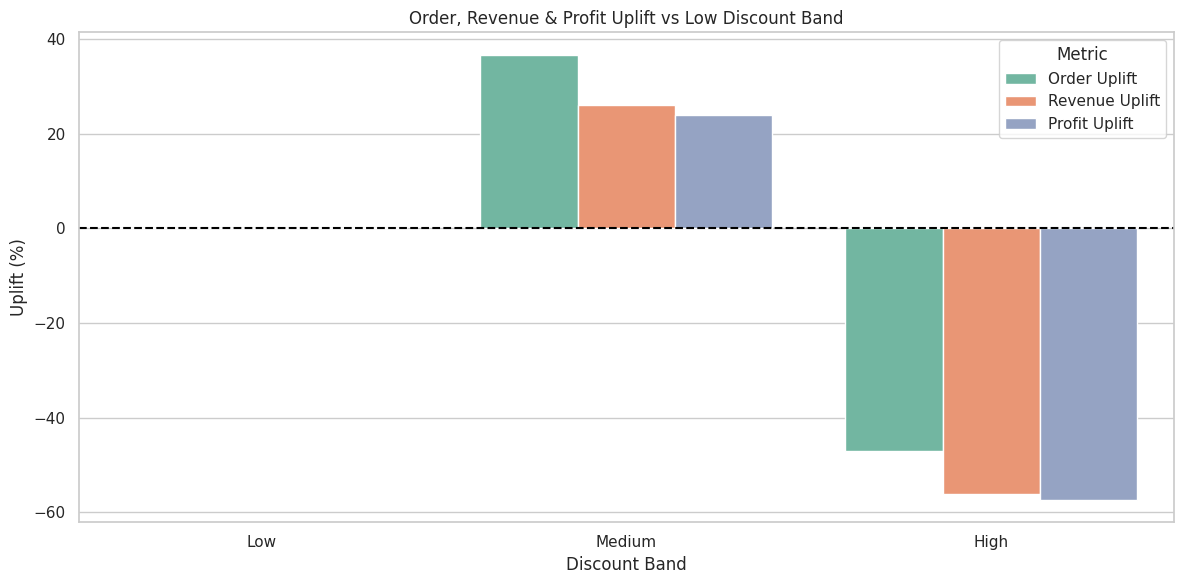

In [23]:
#Uplift Comparison Chart
# Set style
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Plot uplift metrics
uplift_cols = ["order_uplift_vs_low", "revenue_uplift_vs_low", "profit_uplift_vs_low"]
completed_melted = completed_summary.melt(
    id_vars="discount_band", 
    value_vars=uplift_cols, 
    var_name="Metric", 
    value_name="Uplift %"
)

# Clean metric names
completed_melted["Metric"] = completed_melted["Metric"].str.replace("_vs_low", "").str.replace("_", " ").str.title()

# Plot
sns.barplot(data=completed_melted, x="discount_band", y="Uplift %", hue="Metric", palette="Set2")
plt.title("Order, Revenue & Profit Uplift vs Low Discount Band")
plt.ylabel("Uplift (%)")
plt.xlabel("Discount Band")
plt.axhline(0, color="black", linestyle="--")
plt.legend(title="Metric")
plt.tight_layout()
plt.show()


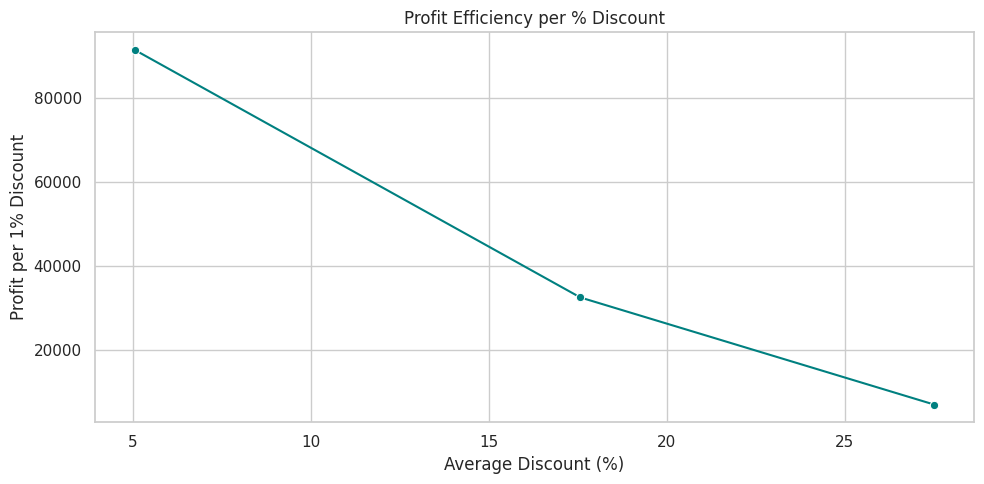

In [ ]:
# Profit Efficiency Chart
plt.figure(figsize=(10, 5))
sns.lineplot(
    data=completed_summary, 
    x="avg_discount", 
    y="profit_per_discount_pct", 
    marker="o", 
    color="teal"
)
plt.title("Profit Efficiency per % Discount")
plt.xlabel("Average Discount (%)")
plt.ylabel("Profit per 1% Discount")
plt.grid(True)
plt.tight_layout()
plt.show()
